In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preparation

## Import library 

In [2]:
import os
import shutil
import glob
import typing
import numpy as np

## Make directory

In [ ]:
main_dir = '/content/drive/MyDrive/Text Detection/SROIE2019/0325updated.task1train(626p)'

In [ ]:
os.mkdir('/content/drive/MyDrive/Text Detection/text-detection-only/SROIE_GT')
os.mkdir('/content/drive/MyDrive/Text Detection/text-detection-only/SROIE_Images')

## Copying files from main SROIE folder to new ground truth and image folders

In [ ]:
for filename in os.listdir(main_dir):
    if filename.endswith('.txt'):
        shutil.copy(os.path.join(main_dir,filename),gt_dir)


In [ ]:
for filename2 in os.listdir(main_dir):
    if filename2.endswith('.jpg'):
        shutil.copy(os.path.join(main_dir,filename2),img_dir)

## Declaring path to training ground truth and Image directories

In [3]:
train_gt_dir = '/content/drive/MyDrive/Text Detection only - JAIR/SROIE_GT'
train_img_dir = '/content/drive/MyDrive/Text Detection only - JAIR/SROIE_Images'

        

## Removing files

In [ ]:
for filename in os.listdir(train_gt_dir):
    lst = os.path.split(os.path.join(train_gt_dir,filename))[1].split(' ')
    if len(lst) > 1:
        os.remove(os.path.join(train_gt_dir,filename))

In [ ]:
for filename in os.listdir(train_img_dir):
    lst = os.path.split(os.path.join(train_img_dir,filename))[1].split(' ')
    if len(lst) > 1:
        os.remove(os.path.join(train_img_dir,filename))

In [4]:
print(len([name for name in os.listdir(train_gt_dir) if os.path.isfile(os.path.join(train_gt_dir,name))]))

626


In [5]:
print(len([name for name in os.listdir(train_img_dir) if os.path.isfile(os.path.join(train_img_dir,name))]))

626


## Creating dataset function to match keras OCR structure and loading dataset

In [6]:
def SROIE_2019_dataset(training_gt_dir, training_img_dir, skip_illegible=False):
    """Get SROIE dataset

    Args:
        training_gt_dir: The directory of ground truth training data.
        skip_illegible: Whether to skip illegible characters.
    
    Returns:
        Lists of (image_path,lines,confidence) tuples.
    """

    dataset = []
    for gt_path in glob.glob(os.path.join(training_gt_dir,"*.txt")):
        image_id = os.path.split(gt_path)[1].split(".")[0]
        image_path = os.path.join(training_img_dir, image_id + ".jpg")
        lines = []
        with open(gt_path,"r") as f:
            current_line: typing.List[typing.Tuple[np.ndarray, str]] = []
            for raw_row in f.read().split('\n'):
                #print(raw_row)
                if raw_row == "":
                    lines.append(current_line)
                    current_line = []
                else:
                    row = raw_row.split(",")
                    word = row[-1]
                    if word == "" and skip_illegible:
                        continue
                    x1,y1,x2,y2,x3,y3,x4,y4 = map(int, row[:8])
                    current_line.append(
                        (np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]), word)
                    )
                    #print(current_line)
                    #print(row)
                    #print(word)
                    #print(gt_path)
        lines = [line for line in lines if line]
        dataset.append((image_path, lines, 1))
    return dataset

        

In [7]:
dataset_SROIE = SROIE_2019_dataset(train_gt_dir,train_img_dir)

In [8]:
print(dataset_SROIE[0])

('/content/drive/MyDrive/Text Detection only - JAIR/SROIE_Images/X51005757304.jpg', [[(array([[147, 153],
       [549, 153],
       [549, 193],
       [147, 193]]), '#000002 BAIFU (M) SDN BHD'), (array([[195, 193],
       [514, 193],
       [514, 226],
       [195, 226]]), 'COMPANY NO(814198-X)'), (array([[179, 230],
       [515, 230],
       [515, 263],
       [179, 263]]), ' IOI MALL'), (array([[210, 265],
       [484, 265],
       [484, 297],
       [210, 297]]), 'PHONE 03-80763806'), (array([[177, 301],
       [516, 301],
       [516, 332],
       [177, 332]]), 'GST ID : 001389649920'), (array([[290, 372],
       [404, 372],
       [404, 403],
       [290, 403]]), 'WELCOME'), (array([[259, 442],
       [436, 442],
       [436, 473],
       [259, 473]]), 'TAX INVOICE'), (array([[100, 548],
       [598, 548],
       [598, 585],
       [100, 585]]), '20/03/2018 7:07PM RCPT NO.18252'), (array([[101, 584],
       [404, 584],
       [404, 613],
       [101, 613]]), 'REG:01 CSH:00000008')

# Training Keras CRAFT Detector with SROIE dataset

In [9]:
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

In [ ]:
!pip install keras_ocr

In [11]:
import keras_ocr

In [12]:
train, validation = sklearn.model_selection.train_test_split(
    dataset_SROIE, train_size=0.7, random_state=43
)

In [13]:
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
        scale=(1.0,1.2),
        rotate=(-5,5)),
    imgaug.augmenters.GaussianBlur(sigma=(0,0.5)),
    imgaug.augmenters.Multiply((0.8,1.2), per_channel=0.2)
    ])
generator_kwargs = {'width':640, 'height': 640}

In [14]:
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)

validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

In [15]:
image,lines,confidence = next(training_image_generator)

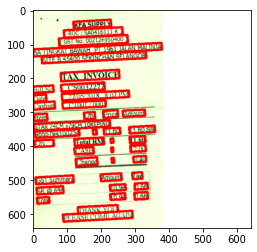

In [16]:
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [17]:
len(train)

438

In [18]:
data_dir = '/content/drive/MyDrive/Text Detection only - JAIR'

In [20]:
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]

detector.model.fit_generator(
    generator = training_generator,
    steps_per_epoch = math.ceil(len(train)/batch_size),
    epochs=5,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=2),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir,'detector_SROIE.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir,'detector_SROIE.h5'))

    ],
    validation_data = validation_generator,
    validation_steps = math.ceil(len(validation)/batch_size)
)


Looking for /root/.keras-ocr/craft_mlt_25k.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
438/438 [==============================] - 788s 2s/step - loss: 0.0382 - val_loss: 0.0505
Epoch 2/5
438/438 [==============================] - 623s 1s/step - loss: 0.0324 - val_loss: 0.0608
Epoch 3/5
438/438 [==============================] - 621s 1s/step - loss: 0.0300 - val_loss: 0.0576


# Inference with Keras CRAFT Detector

In [21]:
detector = keras_ocr.detection.Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [22]:
detector.model.load_weights('/content/drive/MyDrive/Text Detection only - JAIR/detector_SROIE.h5')

In [23]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector)

Looking for /root/.keras-ocr/crnn_kurapan.h5


In [69]:
test_img1 = '/content/drive/MyDrive/Text Detection only - JAIR/0001_img.jpg'


test_sroie1 = '/content/drive/MyDrive/Text Detection only - JAIR/X51009447842.jpg'
test_sroie2 = '/content/drive/MyDrive/Text Detection only - JAIR/X51009008095.jpg'
test_sroie3 = '/content/drive/MyDrive/Text Detection only - JAIR/X51008099100.jpg'

In [113]:
predictions = pipeline.recognize([test_sroie1,test_sroie2,test_sroie3])

In [110]:
print(predictions[1])

[('jigseks', array([[267.22607, 212.05817],
       [399.16046, 208.06018],
       [400.00272, 235.85385],
       [268.06833, 239.85184]], dtype=float32)), ('alal', array([[257.45117, 242.38086],
       [331.54688, 242.38086],
       [331.54688, 254.93945],
       [257.45117, 254.93945]], dtype=float32)), ('noncs180', array([[419.45703, 455.87695],
       [542.53125, 455.87695],
       [542.53125, 482.25   ],
       [419.45703, 482.25   ]], dtype=float32)), ('casmm', array([[ 88.00566 , 910.7447  ],
       [618.0384  , 916.6668  ],
       [617.5874  , 957.0317  ],
       [ 87.554634, 951.10956 ]], dtype=float32)), ('es', array([[  82.88672,  978.31445],
       [ 619.1387 ,  978.31445],
       [ 619.1387 , 1015.99023],
       [  82.88672, 1015.99023]], dtype=float32)), ('', array([[ 157.0385, 1011.9285],
       [ 618.0221, 1014.7742],
       [ 617.8114, 1048.9059],
       [ 156.8278, 1046.0603]], dtype=float32)), ('ss', array([[  79.044525, 1021.52356 ],
       [ 155.14215 , 1013.91376 ]

In [114]:
drawbbox1 = keras_ocr.tools.drawBoxes(
    image=keras_ocr.tools.read(test_sroie1),
    boxes=predictions[0],
    boxes_format = 'predictions'
)

drawbbox2 = keras_ocr.tools.drawBoxes(
    image=keras_ocr.tools.read(test_sroie2),
    boxes=predictions[1],
    boxes_format = 'predictions'
)

drawbbox3 = keras_ocr.tools.drawBoxes(
    image=keras_ocr.tools.read(test_sroie3),
    boxes=predictions[2],
    boxes_format = 'predictions'
)

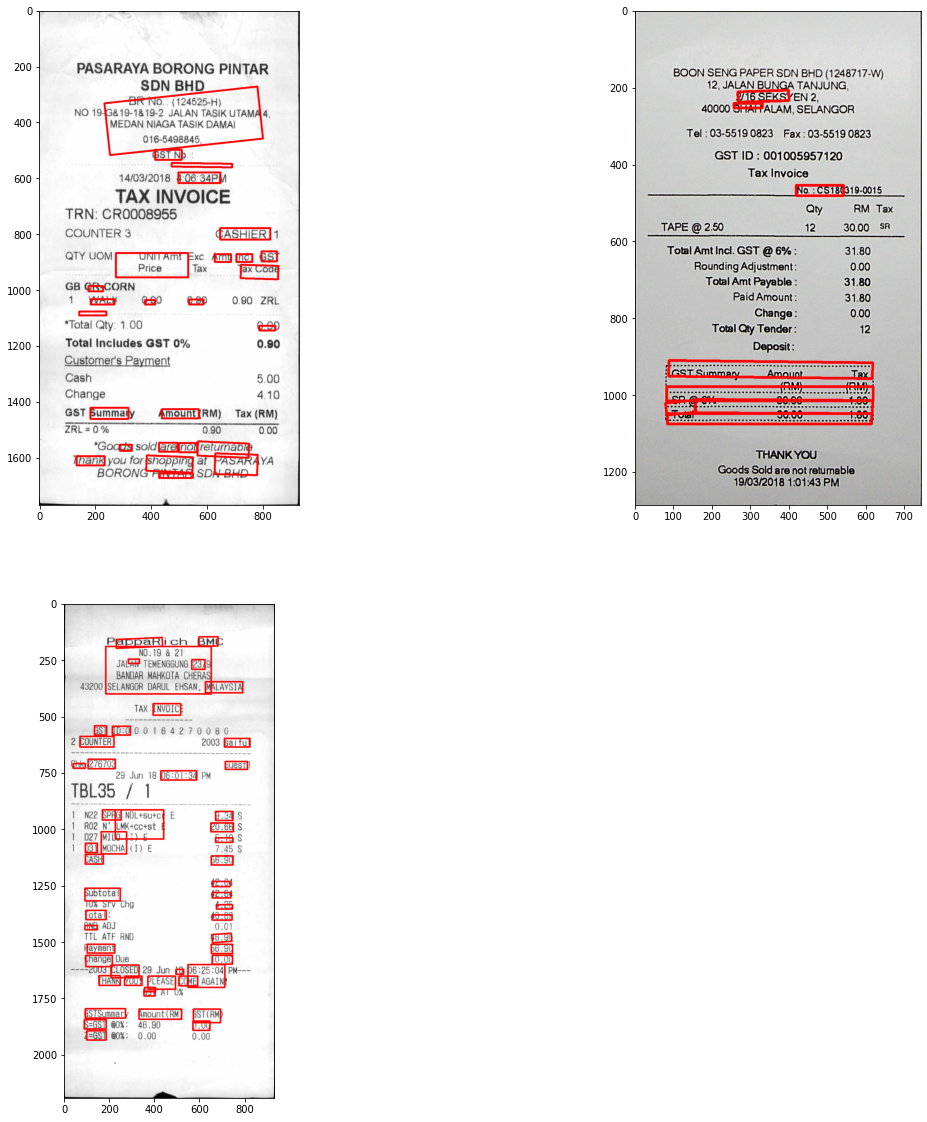

In [116]:
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(2, 2, 1)
plt.imshow(drawbbox1)

fig.add_subplot(2, 2, 2)
plt.imshow(drawbbox2)

fig.add_subplot(2, 2, 3)
plt.imshow(drawbbox3)

# Training Keras CRAFT Detector with ICDAR 2013 dataset

In [ ]:
data_dir = '/content/'

In [ ]:
import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf


In [ ]:
!pip install keras_ocr

     |████████████████████████████████| 41 kB 333 kB/s 
     |████████████████████████████████| 603 kB 8.5 MB/s 
     |████████████████████████████████| 9.5 MB 22.8 MB/s 
     |████████████████████████████████| 900 kB 37.0 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 


In [ ]:
import keras_ocr

In [ ]:
dataset1 = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='/content/',
    skip_illegible=False
)

Looking for /content/icdar2013/Challenge2_Training_Task12_Images.zip
Looking for /content/icdar2013/Challenge2_Training_Task2_GT.zip


In [ ]:
print(dataset1)

In [ ]:
train, validation = sklearn.model_selection.train_test_split(
    dataset1, train_size=0.8, random_state=43
)

In [ ]:
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
        scale=(1.0,1.2),
        rotate=(-5,5)),
    imgaug.augmenters.GaussianBlur(sigma=(0,0.5)),
    imgaug.augmenters.Multiply((0.8,1.2), per_channel=0.2)
    ])
generator_kwargs = {'width':640, 'height': 640}


In [ ]:
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)

validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

In [ ]:
image,lines,confidence = next(training_image_generator)

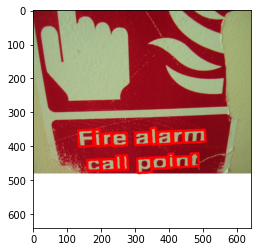

In [ ]:
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [ ]:
len(train)

183

In [ ]:
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]

detector.model.fit_generator(
    generator = training_generator,
    steps_per_epoch = math.ceil(len(train)/batch_size),
    epochs=50,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir,'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir,'detector_icdar2013.h5'))

    ],
    validation_data = validation_generator,
    validation_steps = math.ceil(len(validation)/batch_size)
)


Looking for /root/.keras-ocr/craft_mlt_25k.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
183/183 [==============================] - 198s 1s/step - loss: 0.0119 - val_loss: 0.0155
Epoch 2/50
183/183 [==============================] - 186s 1s/step - loss: 0.0105 - val_loss: 0.0113
Epoch 3/50
183/183 [==============================] - 186s 1s/step - loss: 0.0093 - val_loss: 0.0463
Epoch 4/50
183/183 [==============================] - 186s 1s/step - loss: 0.0064 - val_loss: 0.0120
Epoch 5/50
183/183 [==============================] - 186s 1s/step - loss: 0.0064 - val_loss: 0.0079
Epoch 6/50
183/183 [==============================] - 186s 1s/step - loss: 0.0075 - val_loss: 0.0144
Epoch 7/50
183/183 [==============================] - 185s 1s/step - loss: 0.0065 - val_loss: 0.0123
Epoch 8/50
183/183 [==============================] - 185s 1s/step - loss: 0.0059 - val_loss: 0.0099
Epoch 9/50
183/183 [==============================] - 187s 1s/step - loss: 0.0042 - val_loss: 0.0087
Epoch 10/50
183/183 [==============================] - 185s 1s/step - loss: 0.0038 - val_lo

In [ ]:
detector = keras_ocr.detection.Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
detector.model.load_weights('/content/drive/MyDrive/Text Detection/text-detection-only/detector_icdar2013.h5')

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector)
image = '/content/icdar2013/Challenge2_Training_Task12_Images'

Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
import cv2
image = cv2.imread('/content/icdar2013/Challenge2_Training_Task12_Images/100.jpg')

In [ ]:
imdir = '/content/drive/MyDrive/Text Detection/text-detection-only/0001_img.jpg'

In [ ]:
predictions = pipeline.recognize(['/content/drive/MyDrive/Text Detection/text-detection-only/0001_img.jpg'])[0]

In [ ]:
predictions

[('plult', array([[820.94  , 910.1285],
         [973.1992, 935.505 ],
         [963.0116, 996.6309],
         [810.7524, 971.2544]], dtype=float32)),
 ('obibttsubl', array([[1229.627  ,  935.9398 ],
         [1596.7489 ,  931.76807],
         [1597.4993 ,  997.8026 ],
         [1230.3773 , 1001.97437]], dtype=float32)),
 ('sart', array([[ 990.333  ,  935.5049 ],
         [1123.9766 ,  935.5049 ],
         [1123.9766 ,  993.75977],
         [ 990.333  ,  993.75977]], dtype=float32)),
 ('su', array([[ 842.9824 , 1017.7471 ],
         [ 921.79785, 1017.7471 ],
         [ 921.79785, 1082.8555 ],
         [ 842.9824 , 1082.8555 ]], dtype=float32)),
 ('ber', array([[ 928.65137, 1024.6006 ],
         [1028.0273 , 1024.6006 ],
         [1028.0273 , 1089.709  ],
         [ 928.65137, 1089.709  ]], dtype=float32)),
 ('et', array([[1538.6143, 1028.0273],
         [1603.7227, 1028.0273],
         [1603.7227, 1089.709 ],
         [1538.6143, 1089.709 ]], dtype=float32)),
 ('ilearia', array([[1052.

In [ ]:
boxes=predictions[0][1].reshape((-1,1,2))
boxes

array([[[520.65674, 574.5005 ]],

       [[764.8297 , 578.25696]],

       [[763.8906 , 639.30023]],

       [[519.71765, 635.5437 ]]], dtype=float32)

In [ ]:
drawbbox = keras_ocr.tools.drawBoxes(
    image=keras_ocr.tools.read(imdir),
    boxes=predictions,
    boxes_format = 'predictions'
)

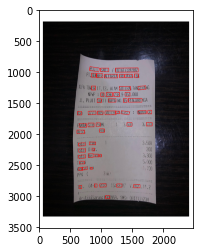

In [ ]:
plt.imshow(drawbbox)